# Webscraping (Mumbai)

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from fake_useragent import UserAgent
import time
import csv

CHROMEDRIVER_PATH = "chromedriver.exe"
CARS24_URL = "https://www.cars24.com/buy-used-mahindra-cars-mumbai/?sort=bestmatch&serveWarrantyCount=true&listingSource=TabFilter&storeCityId=2378"

def get_driver():
    ua = UserAgent()
    user_agent = ua.random

    options = Options()
    options.add_argument("--headless=new")  # Comment this to see browser
    options.add_argument(f"user-agent={user_agent}")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    service = Service(executable_path=CHROMEDRIVER_PATH)
    try:
        driver = webdriver.Chrome(service=service, options=options)
    except Exception as e:
        print(f"Failed to create WebDriver: {e}")
        return None
    return driver

def scroll_to_bottom(driver):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)

def scrape_car_year_and_titles(driver):
    print("\nScraping Car Year & Titles...")
    driver.get(CARS24_URL)
    time.sleep(5)
    scroll_to_bottom(driver)

    car_spans = driver.find_elements(By.XPATH, '//span[contains(text(), "Mahindra")]')
    cars = []
    for span in car_spans:
        text = span.text.strip()
        parts = text.split()
        if len(parts) >= 3 and parts[0].isdigit():
            year = parts[0]
            car_title = " ".join(parts[1:])
            cars.append((year, car_title))
    return cars

def scrape_kilometers_only(driver):
    print("\nScraping Kilometers Driven...")
    driver.get(CARS24_URL)
    time.sleep(5)
    scroll_to_bottom(driver)

    km_elements = driver.find_elements(By.XPATH, '//*[contains(text(), "km")]')
    kms = []
    for elem in km_elements:
        text = elem.text.strip()
        if "km" in text.lower() and any(char.isdigit() for char in text):
            kms.append(text)
    return kms

def clean_km_data(km_list):
    return [km.replace('km', '').strip() for km in km_list if km.strip()]

def scrape_fuel_types(driver):
    print("\nScraping Fuel Types...")
    driver.get(CARS24_URL)
    try:
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located((By.XPATH, '//p[contains(text(), "Diesel") or contains(text(), "Petrol") or contains(text(), "CNG") or contains(text(), "Electric")]'))
        )
    except Exception as e:
        print(" Could not locate fuel type elements:", e)
        return []

    scroll_to_bottom(driver)
    elements = driver.find_elements(By.XPATH, '//p[contains(text(), "Diesel") or contains(text(), "Petrol") or contains(text(), "CNG") or contains(text(), "Electric")]')
    print(f"Found {len(elements)} fuel type elements")

    fuels = []
    for elem in elements:
        text = elem.text.strip()
        for ft in ["Diesel", "Petrol", "CNG", "Electric"]:
            if ft in text:
                fuels.append(ft)
                break
    return fuels

def scrape_transmission_types(driver):
    print("\nScraping Transmission Types...")
    driver.get(CARS24_URL)
    try:
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located((By.XPATH, '//p[contains(text(), "Manual") or contains(text(), "Auto")]'))
        )
    except Exception as e:
        print(" Could not locate transmission type elements:", e)
        return []

    scroll_to_bottom(driver)
    elements = driver.find_elements(By.XPATH, '//p[contains(text(), "Manual") or contains(text(), "Auto")]')
    print(f"Found {len(elements)} transmission type elements")

    transmissions = []
    for elem in elements:
        text = elem.text.strip()
        for t in ["Manual", "Auto"]:
            if t in text:
                transmissions.append(t)
                break
    return transmissions

def scrape_owner_names(driver):
    print("\nScraping Owner Names...")
    driver.get(CARS24_URL)
    try:
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located((By.XPATH, '//p[contains(text(), "owner") or contains(text(), "Owner")]'))
        )
    except Exception as e:
        print("Could not locate owner name elements:", e)
        return []

    scroll_to_bottom(driver)
    owner_elements = driver.find_elements(By.XPATH, '//p[contains(text(), "owner") or contains(text(), "Owner")]')
    print(f" Found {len(owner_elements)} owner name elements")

    return [elem.text.strip() for elem in owner_elements]

def scrape_prices(driver):
    print("\nScraping Car Prices...")
    driver.get(CARS24_URL)
    try:
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located((By.XPATH, '//p[contains(text(),"₹") and contains(text(),"lakh")]'))
        )
    except Exception as e:
        print(" Could not locate price elements:", e)
        return []

    scroll_to_bottom(driver)
    price_elements = driver.find_elements(By.XPATH, '//p[contains(text(),"₹") and contains(text(),"lakh")]')
    print(f" Found {len(price_elements)} price elements")

    return [elem.text.strip() for elem in price_elements if elem.text.strip()]

def scrape_locations(driver):
    print("\nScraping Car Locations...")
    driver.get(CARS24_URL)
    try:
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located((By.XPATH, '//div[contains(@class, "styles_ellipsis__")]'))
        )
    except Exception as e:
        print(" Could not locate location elements:", e)
        return []

    scroll_to_bottom(driver)
    elements = driver.find_elements(By.XPATH, '//div[contains(@class, "styles_ellipsis__")]//p')

    locations = []
    for elem in elements:
        text = elem.text.strip()
        if "," in text and "EMI" not in text and len(text.split()) <= 5:
            locations.append(text)
    return locations

# ---------- MAIN EXECUTION ----------
driver = get_driver()
if driver is None:
    print("Driver setup failed. Aborting.")
else:
    try:
        cars = scrape_car_year_and_titles(driver)
        kms = scrape_kilometers_only(driver)
        fuels = scrape_fuel_types(driver)
        transmissions = scrape_transmission_types(driver)
        owners = scrape_owner_names(driver)
        prices = scrape_prices(driver)
        locations = scrape_locations(driver)
    finally:
        driver.quit()

    cleaned_kms = clean_km_data(kms)

    print("\n Car Year & Titles:")
    for year, title in cars:
        print(f"- {year} {title}")

    print("\n Kilometers Driven:")
    for km in cleaned_kms:
        print(f"- {km} km")

    print("\n Fuel Types Found:")
    for fuel in fuels:
        print(f"- {fuel}")

    print("\n Transmission Types Found:")
    for t in transmissions:
        print(f"- {t}")

    print("\n Owner Names Found:")
    for owner in owners:
        print(f"- {owner}")

    print("\n Car Prices Found:")
    for price in prices:
        print(f"- {price}")

    print("\n Car Locations Found:")
    for loc in locations:
        print(f"- {loc}")

    # Save to CSV
    print("\n Saving to CSV...")
    filename = "cars24_scraped_hyd_data.csv"
    car_data = []

    min_len = min(len(cars), len(cleaned_kms), len(fuels), len(transmissions), len(owners), len(prices), len(locations))
    for i in range(min_len):
        car_data.append({
            "Year": cars[i][0],
            "Title": cars[i][1],
            "Kilometers": cleaned_kms[i],
            "Fuel": fuels[i],
            "Transmission": transmissions[i],
            "Owner": owners[i],
            "Price": prices[i],
            "Location": locations[i]
        })

    with open(filename, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=car_data[0].keys())
        writer.writeheader()
        writer.writerows(car_data)

    print(f" CSV file saved as '{filename}'")


## Similar code was used for different cities to extract data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_data = pd.read_csv("/content/sample_data/merged_mahindra.csv")

In [ ]:
df_data['Transmission'] = df_data['Transmission'].replace('Automatic', 'Auto')

In [ ]:
df_data.head()

,Year,Title,Kilometers,Fuel,Transmission,Owner,Price,Location
0,2022,Bolero 2022,63.73k,Diesel,Manual,1st owner,₹9.00 lakh,"Mansarovar, Jaipur"
1,2017,Xuv500 2017,77.02k,Diesel,Manual,1st owner,₹7.81 lakh,"Mansarovar, Jaipur"
2,2021,Xuv300 2021,99.78k,Petrol,Manual,1st owner,₹6.42 lakh,"Mansarovar, Jaipur"
3,2022,Xuv300 2022,45.90k,Diesel,Manual,1st owner,₹9.50 lakh,"Mansarovar, Jaipur"
4,2018,Xuv500 2018,88.88k,Diesel,Auto,1st owner,₹10.45 lakh,Jaipur


In [ ]:
df_data.isnull().sum()

,0
Year,0
Title,0
Kilometers,0
Fuel,0
Transmission,0
Owner,0
Price,0
Location,0


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          52 non-null     int64 
 1   Title         52 non-null     object
 2   Kilometers    52 non-null     object
 3   Fuel          52 non-null     object
 4   Transmission  52 non-null     object
 5   Owner         52 non-null     object
 6   Price         52 non-null     object
 7   Location      52 non-null     object
dtypes: int64(1), object(7)
memory usage: 3.4+ KB


In [ ]:
df_data['Kilometers'] = df_data['Kilometers'].astype(str).str.replace('km', '', regex=False).str.replace(',', '', regex=False)

def convert_kilometers(km_str):
    km_str = km_str.strip()
    if km_str.lower().endswith('k'):
        return float(km_str[:-1]) * 1000
    elif km_str.lower().endswith('l'):
        return float(km_str[:-1]) * 100000 # Assuming 'L' means Lakhs
    else:
        return float(km_str)

df_data['Kilometers'] = df_data['Kilometers'].apply(convert_kilometers)

In [ ]:
df_data.head()

,Year,Title,Kilometers,Fuel,Transmission,Owner,Price,Location
0,2022,Bolero 2022,63730.0,Diesel,Manual,1st owner,₹9.00 lakh,"Mansarovar, Jaipur"
1,2017,Xuv500 2017,77020.0,Diesel,Manual,1st owner,₹7.81 lakh,"Mansarovar, Jaipur"
2,2021,Xuv300 2021,99780.0,Petrol,Manual,1st owner,₹6.42 lakh,"Mansarovar, Jaipur"
3,2022,Xuv300 2022,45900.0,Diesel,Manual,1st owner,₹9.50 lakh,"Mansarovar, Jaipur"
4,2018,Xuv500 2018,88880.0,Diesel,Auto,1st owner,₹10.45 lakh,Jaipur


In [ ]:
df_data['Price'] = df_data['Price'].astype(str).str.replace('[₹,]', '', regex=True).str.replace('lakh', '', regex=False)
df_data['Price'] = pd.to_numeric(df_data['Price'], errors='coerce') * 100000
df_data.head()


,Year,Title,Kilometers,Fuel,Transmission,Owner,Price,Location
0,2022,Bolero 2022,63730.0,Diesel,Manual,1st owner,900000.0,"Mansarovar, Jaipur"
1,2017,Xuv500 2017,77020.0,Diesel,Manual,1st owner,781000.0,"Mansarovar, Jaipur"
2,2021,Xuv300 2021,99780.0,Petrol,Manual,1st owner,642000.0,"Mansarovar, Jaipur"
3,2022,Xuv300 2022,45900.0,Diesel,Manual,1st owner,950000.0,"Mansarovar, Jaipur"
4,2018,Xuv500 2018,88880.0,Diesel,Auto,1st owner,1045000.0,Jaipur


In [ ]:
df_data.describe()

,Year,Kilometers,Price
count,52.000000,52.000000,5.200000e+01
mean,2019.961538,70475.576923,8.852885e+05
std,2.903423,47076.993607,2.838746e+05
min,2012.000000,3350.000000,2.200000e+05
25%,2018.000000,40287.500000,7.132500e+05
50%,2021.000000,63200.000000,9.330000e+05
75%,2022.000000,91980.000000,1.087000e+06
max,2024.000000,230000.000000,1.490000e+06


In [ ]:
df_data.duplicated().sum()

np.int64(0)

In [ ]:
df_data['Location'].value_counts()

,count
Location,
Jaipur,16
"Kompally, Hyderabad",11
"Bachupally, Hyderabad",7
"Mansarovar, Jaipur",4
"Mulund West, Mumbai",3
"Upperpally, Attapur, Hyderabad",2
"Regency Anantam, Dombivli East",2
"M3M Urbana, Golf Course Ext., Gurugram",2
"Piyush Mahendra Mall, opp. Dussehra Ground, NIT - 3",1


In [ ]:
df_data.Title.value_counts()

,count
Title,
Mahindra Thar,9
Mahindra XUV500,6
Mahindra BOLERO NEO,5
Mahindra XUV300,5
Mahindra Bolero,4
Xuv500 2019,3
Xuv300 2021,1
Xuv300 2022,1
Bolero 2022,1


## Visualization

/tmp/ipython-input-47-4073441270.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fuel', data=df_data, palette='Set2')


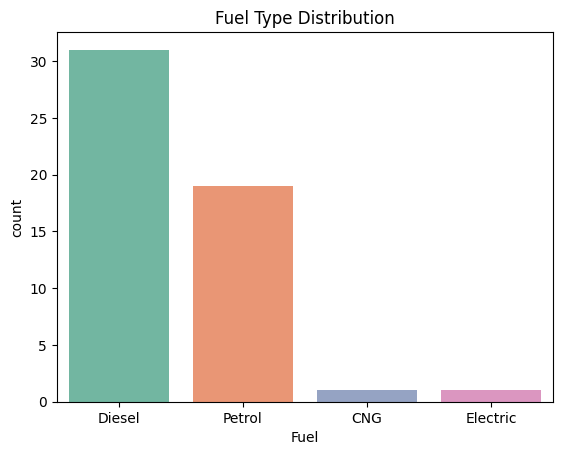

In [ ]:
sns.countplot(x='Fuel', data=df_data, palette='Set2')
plt.title('Fuel Type Distribution')
plt.show()

/tmp/ipython-input-66-1032724815.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Transmission', data=df_data, palette='coolwarm')


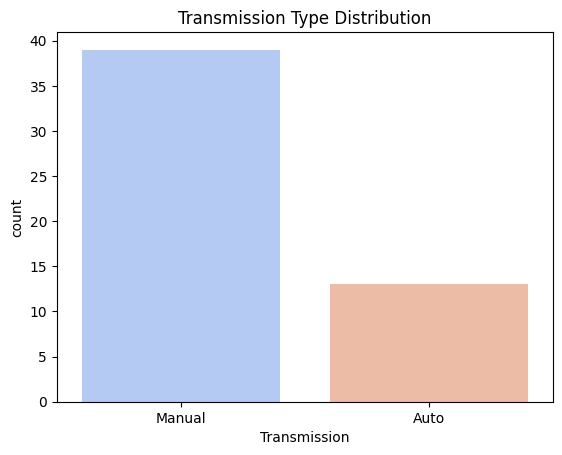

In [ ]:
sns.countplot(x='Transmission', data=df_data, palette='coolwarm')
plt.title('Transmission Type Distribution')
plt.show()

/tmp/ipython-input-49-3791770948.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Owner', data=df_data, palette='Set1')


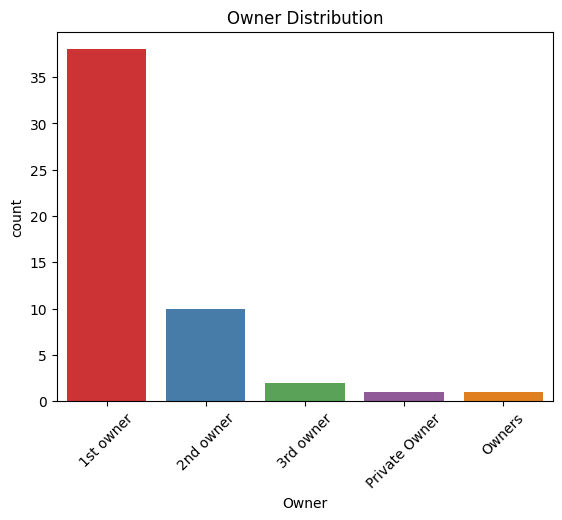

In [ ]:
sns.countplot(x='Owner', data=df_data, palette='Set1')
plt.title('Owner Distribution')
plt.xticks(rotation=45)
plt.show()

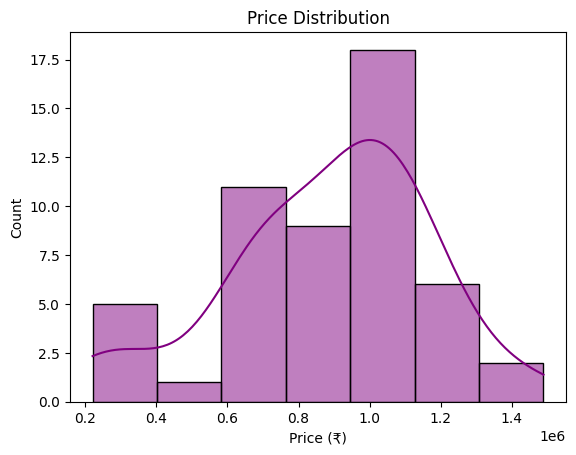

In [ ]:
sns.histplot(df_data['Price'], kde=True, color='purple')
plt.title('Price Distribution')
plt.xlabel('Price (₹)')
plt.show()

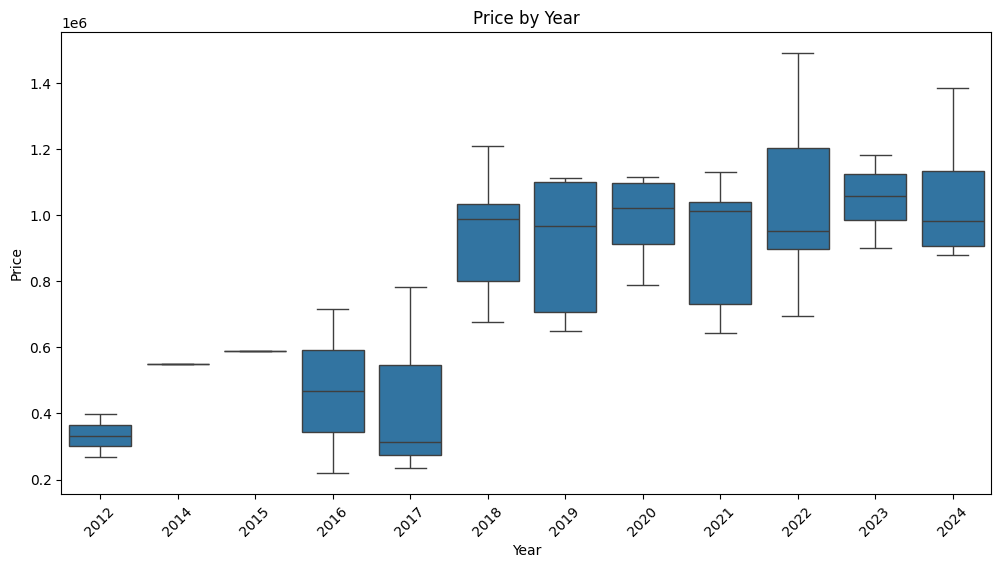

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Year', y='Price', data=df_data)
plt.title('Price by Year')
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-52-3851770905.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Fuel', y='Price', data=fuel_price, palette='pastel')


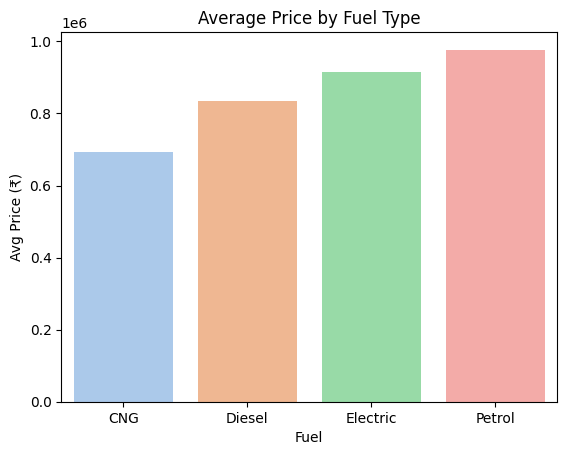

In [ ]:
fuel_price = df_data.groupby('Fuel')['Price'].mean().reset_index()
sns.barplot(x='Fuel', y='Price', data=fuel_price, palette='pastel')
plt.title('Average Price by Fuel Type')
plt.ylabel('Avg Price (₹)')
plt.show()

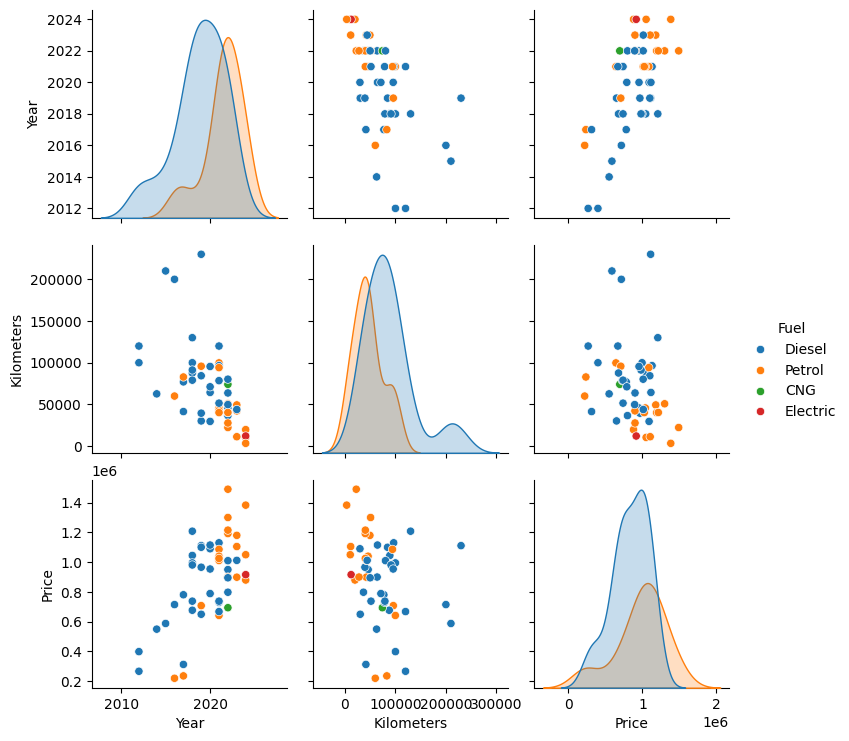

In [ ]:
sns.pairplot(df_data, hue='Fuel')


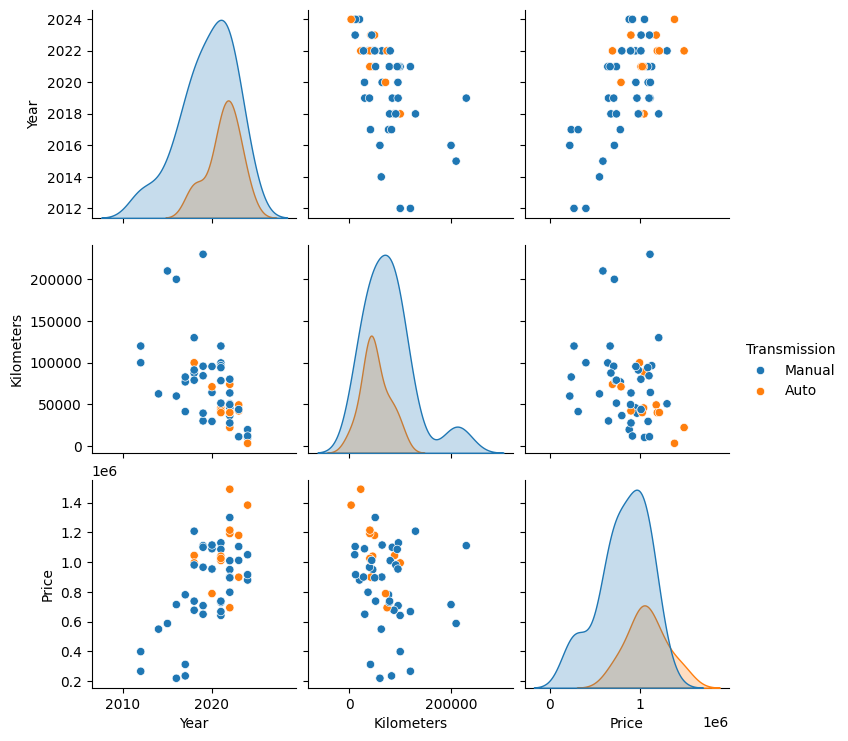

In [ ]:
sns.pairplot(df_data, hue='Transmission')


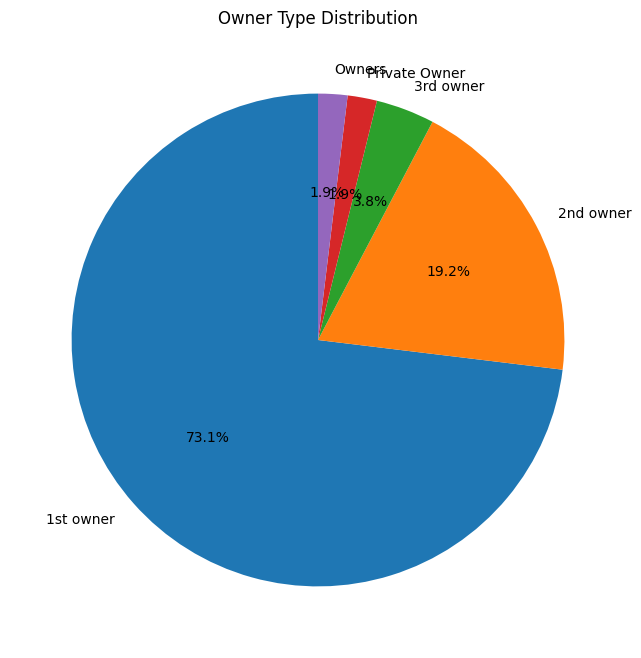

In [ ]:
plt.figure(figsize=(8,8))
df_data['Owner'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Owner Type Distribution')
plt.ylabel('')
plt.show()

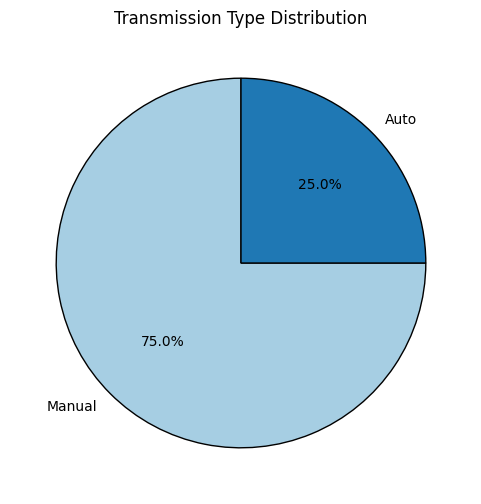

In [ ]:
plt.figure(figsize=(6, 6))
df_data['Transmission'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Paired'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Transmission Type Distribution')
plt.ylabel('')
plt.show()

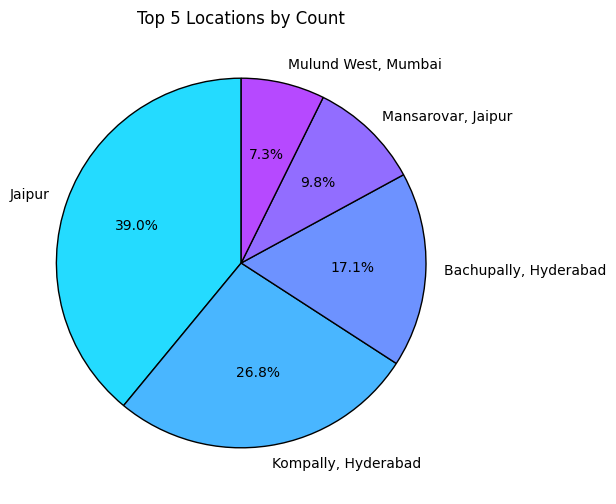

In [ ]:
plt.figure(figsize=(6, 6))
df_data['Location'].value_counts().head(5).plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('cool'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Top 5 Locations by Count')
plt.ylabel('')
plt.show()

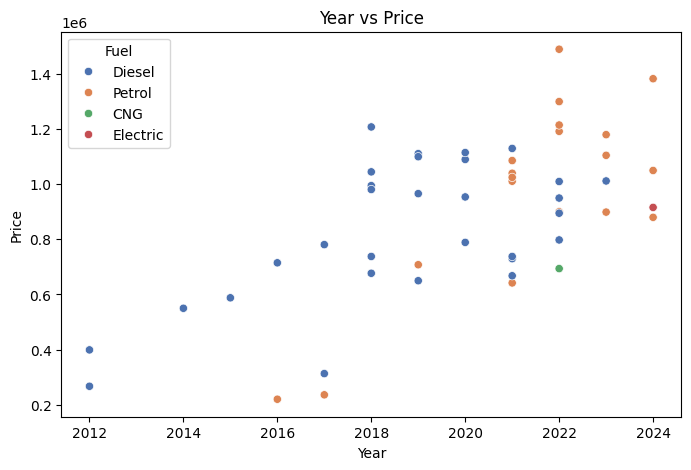

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Year', y='Price', hue='Fuel', data=df_data, palette='deep')
plt.title('Year vs Price')
plt.show()

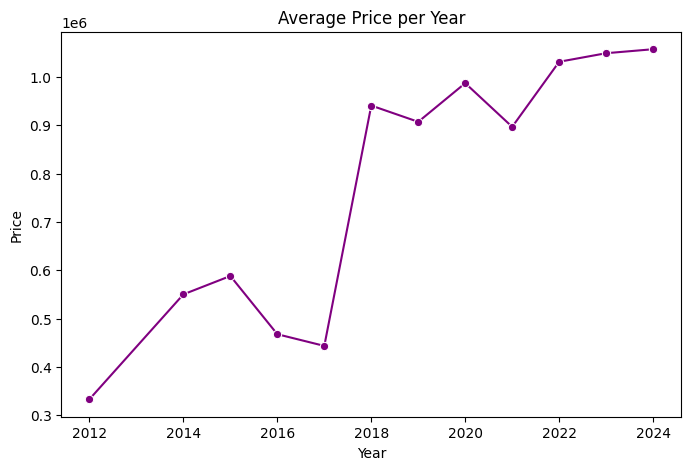

In [ ]:
avg_price_per_year = df_data.groupby('Year')['Price'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.lineplot(x='Year', y='Price', data=avg_price_per_year, marker='o', color='purple')
plt.title('Average Price per Year')
plt.show()

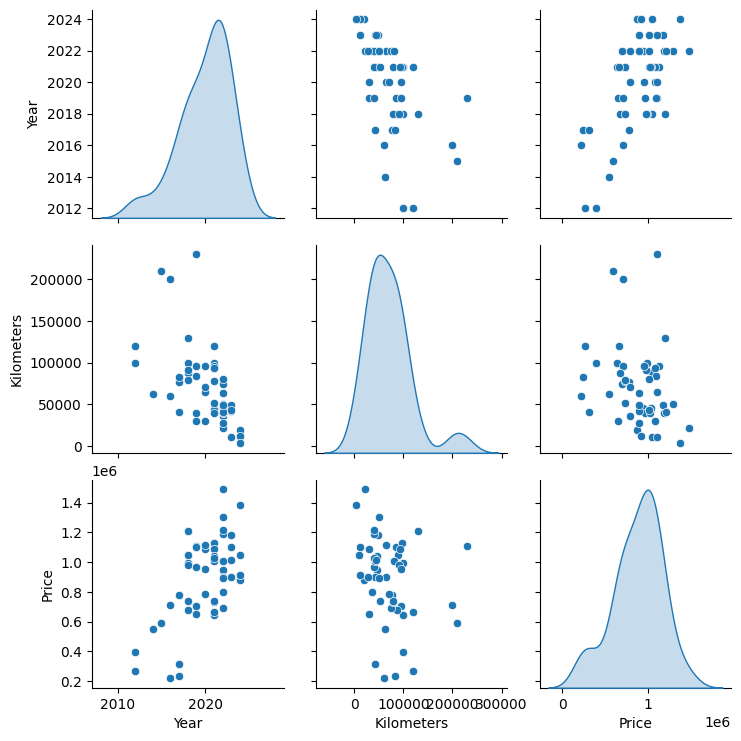

In [ ]:
sns.pairplot(df_data[['Year', 'Kilometers', 'Price']], diag_kind='kde')
plt.show()

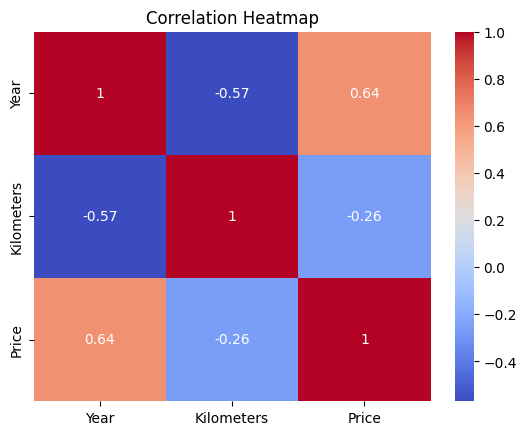

In [ ]:
sns.heatmap(df_data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

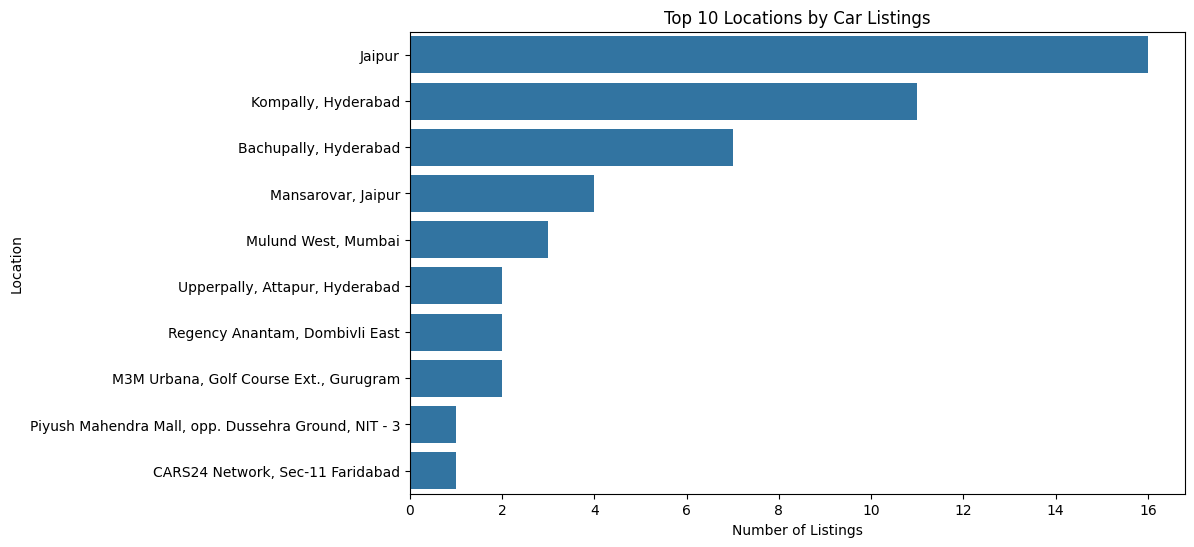

In [ ]:
top_locations = df_data['Location'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_locations.index, x=top_locations.values)
plt.title('Top 10 Locations by Car Listings')
plt.xlabel('Number of Listings')
plt.ylabel('Location')
plt.show()

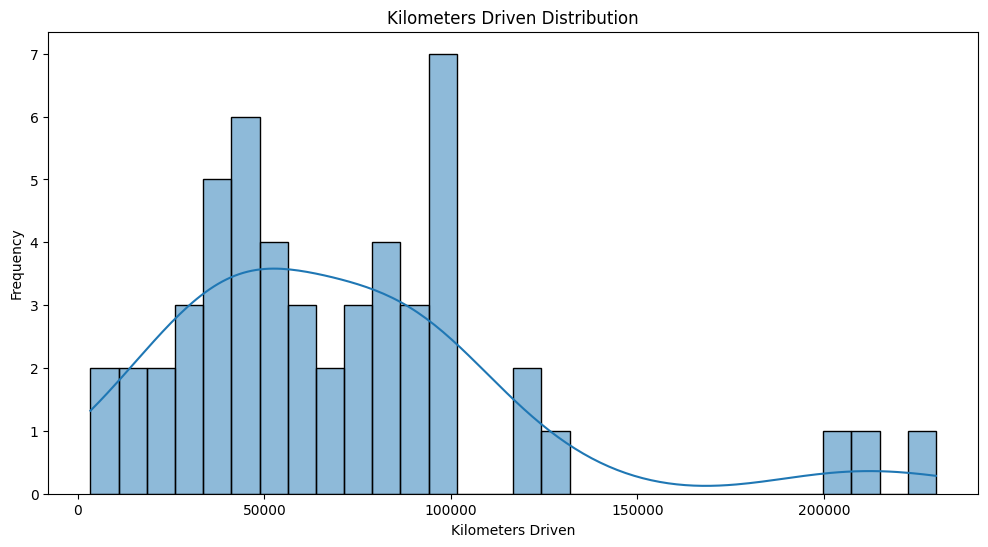

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df_data['Kilometers'].dropna(), bins=30, kde=True)
plt.title('Kilometers Driven Distribution')
plt.xlabel('Kilometers Driven')
plt.ylabel('Frequency')
plt.show()



This report provides an overview of the code's execution and analysis performed in the Jupyter Notebook/Google Colaboratory session.

**Code Execution and Data Acquisition:**

1.  **Web Scraping Setup:**
    *   Initializes necessary libraries: `selenium`, `csv`, `numpy`, `pandas`, `matplotlib.pyplot`, `seaborn`.
    *   Sets constants for the Chromedriver path and the target URL (`CARS24_URL` for Mahindra cars in Mumbai).
    *   Defines `get_driver()` to configure and initialize a headless Chrome WebDriver with a random user agent. Includes error handling for driver creation.
    *   Defines `scroll_to_bottom()` to scroll down the webpage.

2.  **Data Scraping Functions:**
    *   Defines functions to scrape specific data points from the `CARS24_URL`:
        *   `scrape_car_year_and_titles()`: Extracts the year and title of cars.
        *   `scrape_kilometers_only()`: Extracts the kilometers driven (including cleaning).
        *   `scrape_fuel_types()`: Extracts the fuel type (Diesel, Petrol, CNG, Electric).
        *   `scrape_transmission_types()`: Extracts the transmission type (Manual, Auto).
        *   `scrape_owner_names()`: Extracts the number of owners.
        *   `scrape_prices()`: Extracts the car price in Rupees.
        *   `scrape_locations()`: Extracts the car location.
    *   Each scraping function navigates to the `CARS24_URL`, waits for elements to load using `WebDriverWait` with `expected_conditions`, scrolls to the bottom, finds elements using XPath, and extracts the relevant text. Error handling for element location is included.

3.  **Main Execution:**
    *   Calls `get_driver()` to initialize the driver.
    *   If the driver is successfully initialized, it calls each scraping function to collect data.
    *   A `try...finally` block ensures that `driver.quit()` is called to close the browser session even if errors occur during scraping.
    *   Calls `clean_km_data()` to remove 'km' and commas from the kilometers data.
    *   Prints a summary of the scraped data for each category.

4.  **CSV Data Saving:**
    *   Creates a list of dictionaries (`car_data`) by combining the scraped data lists. It takes the minimum length of all lists to avoid index errors.
    *   Specifies the output filename (`cars24_scraped_hyd_data.csv`). *Note: The filename 'hyd_data' is inconsistent with the scraping target 'Mumbai'. This might be a copy-paste error in the original code.*
    *   Opens the specified CSV file in write mode (`'w'`) with `newline=''` and `encoding='utf-8'`.
    *   Uses `csv.DictWriter` to write the header row and then all data rows from `car_data` to the CSV file.
    *   Prints a confirmation message after saving the CSV.

**Data Loading and Preprocessing:**

5.  **Load Data from CSV:**
    *   Loads data from a CSV file named `merged_mahindra.csv` located in `/content/sample_data/` into a pandas DataFrame `df_data`. *Note: This loads a pre-existing file, not the one just scraped, implying the scraping part was likely used to create this merged file previously.*

6.  **Data Cleaning and Transformation:**
    *   Replaces 'Automatic' with 'Auto' in the 'Transmission' column for consistency.
    *   Checks for missing values using `isnull().sum()` and prints the result.
    *   Displays data types and non-null counts using `info()`.
    *   Cleans the 'Kilometers' column by removing 'km', commas, and then converts it to a string before applying the cleaning.
    *   Defines `convert_kilometers()` to handle 'k' (thousands) and 'l' (lakhs) suffixes in the 'Kilometers' column and converts the values to numeric (float).
    *   Applies `convert_kilometers()` to the 'Kilometers' column.
    *   Cleans the 'Price' column by removing '₹', commas, and 'lakh'. Converts the cleaned string to numeric (float) and multiplies by 100,000 to represent prices in Rupees. `errors='coerce'` handles potential conversion issues by turning invalid values into NaN.

7.  **Data Inspection and Summarization:**
    *   Displays the first few rows of the cleaned DataFrame using `head()`.
    *   Provides descriptive statistics of the DataFrame using `describe()`.
    *   Checks for and counts duplicate rows using `duplicated().sum()`.
    *   Shows the frequency count of values in the 'Location' and 'Title' columns using `value_counts()`.

**Data Visualization:**

8.  **Visualizations using Matplotlib and Seaborn:**
    *   Generates several plots to visualize the cleaned data:
        *   Count plot of 'Fuel' type distribution using `seaborn.countplot`.
        *   Count plot of 'Transmission' type distribution using `seaborn.countplot`.
        *   Count plot of 'Owner' distribution using `seaborn.countplot` and rotates x-axis labels for readability.
        *   Histogram of 'Price' distribution using `seaborn.histplot` with a kernel density estimate (kde).
        *   Box plot of 'Price' vs 'Year' using `seaborn.boxplot` and rotates x-axis labels.
        *   Bar plot showing the average 'Price' by 'Fuel' type using `seaborn.barplot`.
        *   Pair plots (`seaborn.pairplot`) to visualize relationships between numerical features, colored by 'Fuel' and 'Transmission' type.
        *   Pie chart of 'Owner' type distribution using `matplotlib.pyplot.pie`.
        *   Pie chart of 'Transmission' type distribution using `matplotlib.pyplot.pie`.
        *   Pie chart of the top 5 'Location' counts using `matplotlib.pyplot.pie`.
        *   Scatter plot of 'Year' vs 'Price' with 'Fuel' as hue using `seaborn.scatterplot`.
        *   Line plot showing the average 'Price' per 'Year' using `seaborn.lineplot`.
        *   Pair plot of 'Year', 'Kilometers', and 'Price' with kernel density estimates on the diagonal using `seaborn.pairplot`.
        *   Heatmap of the correlation matrix for numerical columns using `seaborn.heatmap`.
        *   Bar plot of the top 10 'Location' counts using `seaborn.barplot`.
        *   Histogram of 'Kilometers' driven distribution using `seaborn.histplot`.

This report covers the key steps performed in the provided code: web scraping, data cleaning, data loading, and extensive data visualization to understand the characteristics of the used car data.

Based on the visualizations generated by the provided code, here is a detailed analysis of each plot:

**1. Fuel Type Distribution (Count Plot):**

*   **Visualization:** A bar chart showing the count of cars for each fuel type (Diesel, Petrol, CNG, Electric).
*   **Analysis:** This plot reveals the prevalence of different fuel types in the dataset. It likely shows that Diesel and Petrol cars are the most common, which is typical for the used car market. CNG and Electric cars are expected to have significantly lower counts, reflecting their smaller market share in the used segment compared to traditional fuel types. This distribution is important for understanding market trends and potentially identifying segments with less supply.

**2. Transmission Type Distribution (Count Plot):**

*   **Visualization:** A bar chart showing the count of cars with Manual vs Auto transmission.
*   **Analysis:** This plot highlights the proportion of cars available with each transmission type. It helps understand the buyer preference or market availability for manual vs. automatic cars. In many markets, manual transmission cars are more common in the used segment, but the distribution can vary by region and car segment. The visualization directly shows which transmission type dominates the dataset.

**3. Owner Distribution (Count Plot):**

*   **Visualization:** A bar chart showing the count of cars based on the number of previous owners (e.g., First Owner, Second Owner, etc.). The x-axis labels are rotated for better readability.
*   **Analysis:** This plot indicates how many cars are being sold by their first, second, or subsequent owners. Cars with fewer owners (especially first-owner cars) are often perceived as being in better condition and may command higher prices. This visualization gives insights into the history of the cars available in the market.

**4. Price Distribution (Histogram with KDE):**

*   **Visualization:** A histogram showing the frequency of cars within different price ranges, overlaid with a Kernel Density Estimate (KDE) line.
*   **Analysis:** This plot provides a visual representation of the overall price distribution of the cars. The histogram shows the bins of price values and the number of cars falling into each bin. The KDE line provides a smoothed estimate of the distribution. It helps identify the most common price ranges for used Mahindra cars in the surveyed cities and can reveal if the distribution is skewed (e.g., towards lower or higher prices) or has multiple peaks.

**5. Price by Year (Box Plot):**

*   **Visualization:** Box plots showing the distribution of prices for each manufacturing year present in the dataset. X-axis labels are rotated.
*   **Analysis:** Box plots are excellent for comparing the distribution of a numerical variable (Price) across different categories (Year). For each year, the box plot shows the median price, the interquartile range (IQR), and potential outliers. This plot is crucial for understanding the relationship between car age and price. As expected, older cars are generally cheaper, and the box plots should show a decreasing trend in price with decreasing year (increasing age). It also helps identify years with a wider spread in prices, which might indicate variations in car models or condition within that year.

**6. Average Price by Fuel Type (Bar Plot):**

*   **Visualization:** A bar chart showing the average price of cars for each fuel type.
*   **Analysis:** This plot compares the average selling price of cars based on their fuel type. It can reveal if there's a significant price difference between Diesel, Petrol, CNG, and Electric vehicles in the used market. For example, Diesel cars might have a higher average price due to their initial cost or demand for certain segments.

**7. Pair Plots (Fuel and Transmission Hue):**

*   **Visualization:** Scatter plots for all pairs of numerical variables (Year, Kilometers, Price, potentially others if present), with points colored based on 'Fuel' type in one set and 'Transmission' type in another. Diagonal plots show the distribution (usually histograms or KDEs) of individual variables.
*   **Analysis:** Pair plots are useful for exploring relationships between multiple variables simultaneously.
    *   **Colored by Fuel:** Allows visual inspection of how the relationships between numerical variables (e.g., Year vs Price, Kilometers vs Price) differ based on fuel type. For instance, the relationship between Year and Price might be different for Diesel vs. Petrol cars.
    *   **Colored by Transmission:** Similar to the fuel plot, this helps observe if the relationships between numerical variables vary between Manual and Auto transmission cars.
    *   The scatter plots in the off-diagonal cells show potential correlations. For example, Year and Kilometers might have a negative relationship (older cars tend to have more kilometers driven), and Kilometers and Price might have a negative relationship (higher kilometers generally mean lower price).

**8. Owner Type Distribution (Pie Chart):**

*   **Visualization:** A pie chart showing the percentage of cars belonging to each owner category.
*   **Analysis:** This provides a clear visual summary of the proportion of cars with different ownership histories. It's a more direct way to see the dominant owner categories than the count plot, showing the percentage of first-owner cars, second-owner cars, etc., relative to the whole dataset.

**9. Transmission Type Distribution (Pie Chart):**

*   **Visualization:** A pie chart showing the percentage of cars with Manual vs. Auto transmission.
*   **Analysis:** Similar to the count plot, this provides a percentage breakdown of transmission types, offering a clear picture of the market share for each in the used segment.

**10. Top 5 Locations by Count (Pie Chart):**

*   **Visualization:** A pie chart showing the percentage of cars originating from the top 5 most frequent locations in the dataset.
*   **Analysis:** This visualization highlights the key geographical areas from which the cars in the dataset are sourced. It indicates where the majority of listings are concentrated, which could be important for market analysis or logistics.

**11. Year vs Price (Scatter Plot with Fuel Hue):**

*   **Visualization:** A scatter plot showing the relationship between Year and Price, with data points colored according to their Fuel type.
*   **Analysis:** This plot reinforces the relationship seen in the box plots but shows individual data points. It allows for a more granular view of how price changes with age, and whether this relationship differs visually across different fuel types. You might see clusters of different fuel types on the plot.

**12. Average Price per Year (Line Plot):**

*   **Visualization:** A line plot showing the average price of cars for each year, connected by a line.
*   **Analysis:** This plot provides a clear trend line for how the average price of a used Mahindra car changes as it gets older (year decreases). It should show a generally decreasing trend, confirming the impact of depreciation. The markers on the line indicate the specific average price for each year.

**13. Pair Plot (Year, Kilometers, Price):**

*   **Visualization:** A pair plot focusing specifically on the relationships between the three key numerical variables: Year, Kilometers, and Price. Diagonal plots show the distribution (KDE) of each variable.
*   **Analysis:** This plot is a focused version of the earlier pair plots, specifically designed to explore the relationships between these three crucial factors in used car pricing.
    *   **Year vs. Price:** Likely shows a negative correlation (older cars tend to be cheaper).
    *   **Kilometers vs. Price:** Likely shows a negative correlation (more kilometers tend to mean lower price).
    *   **Year vs. Kilometers:** Likely shows a negative correlation (older cars tend to have accumulated more kilometers).
    *   The KDE plots on the diagonal provide a smooth estimate of the distribution for Year, Kilometers, and Price, complementing the earlier histogram.

**14. Correlation Heatmap:**

*   **Visualization:** A heatmap showing the correlation coefficients between all pairs of numerical variables in the DataFrame. Annotations show the specific correlation values.
*   **Analysis:** This provides a quantitative measure of the linear relationship between numerical variables. Values close to 1 indicate a strong positive correlation, values close to -1 indicate a strong negative correlation, and values close to 0 indicate a weak or no linear correlation. It will likely show strong negative correlations between Year and Price, Kilometers and Price, and Year and Kilometers, confirming the visual observations from the scatter plots. Correlations between other numerical variables (if any) will also be displayed. This plot is essential for identifying strong linear relationships and multicollinearity (high correlation between predictor variables).

**15. Top 10 Locations by Car Listings (Bar Plot):**

*   **Visualization:** A horizontal bar plot showing the top 10 locations with the highest number of car listings.
*   **Analysis:** Similar to the location pie chart, this provides a ranked view of the locations with the most listings. It's useful for identifying the major hubs for used car sales in the surveyed region.

**16. Kilometers Driven Distribution (Histogram with KDE):**

*   **Visualization:** A histogram showing the frequency distribution of the Kilometers Driven values, overlaid with a KDE line.
*   **Analysis:** This plot shows the distribution of the mileage of the cars in the dataset. It helps understand the typical range of kilometers for used cars in this market. The distribution might be skewed, with a higher frequency of cars in lower to medium mileage ranges. It can also reveal if there are many high-mileage vehicles.

In summary, the visualizations collectively provide a comprehensive understanding of the dataset, including the distribution of categorical variables (Fuel, Transmission, Owner, Location), the distribution of numerical variables (Price, Kilometers, Year), and the relationships between these variables. They effectively illustrate key factors influencing the price and characteristics of used Mahindra cars in the scraped market.